## Build MRCNN Model
Pass data through MRCNN and then FCN and investigte output values from FCN
- First we generate the heatmaps, and also visually cehck them. 
- the we pass the heatmaps to the routine that prodcues the scores 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
 
import os, sys, math, io, time, gc, argparse, platform, pprint
import numpy as np
from datetime import datetime   
sys.path.append('../')
print(os.getcwd())
print()

# import tensorflow as tf
# import keras
# import keras.backend as KB
# import mrcnn.model_mrcnn  as mrcnn_modellib
# import mrcnn.model_fcn    as fcn_modellib
# from mrcnn.prep_notebook import 
# import mrcnn.new_shapes   as shapes
# from mrcnn.utils        import command_line_parser, Paths
# from mrcnn.config       import Config
# from mrcnn.dataset      import Dataset 
# from mrcnn.utils        import log, stack_tensors, stack_tensors_3d, write_stdout
# from mrcnn.datagen      import data_generator, load_image_gt
# from mrcnn.callbacks    import get_layer_output_1,get_layer_output_2
# from mrcnn.coco          import CocoDataset, CocoConfig, CocoInferenceConfig, evaluate_coco, build_coco_results
# from mrcnn.prep_notebook import mrcnn_coco_train

import mrcnn.visualize    as visualize
from mrcnn.coco          import CocoConfig, prep_coco_dataset
from mrcnn.utils         import Paths
import matplotlib.pyplot as plt
from matplotlib import cm

E:\git_projs\MRCNN3\notebooks



Using TensorFlow backend.


In [2]:
pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4,threshold=1000, suppress = True)
start_time = datetime.now().strftime("%m-%d-%Y @ %H:%M:%S")
print()
print('--> Execution started at:', start_time)
# print("    Tensorflow Version: {}   Keras Version : {} ".format(tf.__version__,keras.__version__))

##------------------------------------------------------------------------------------
## setup project directories
##---------------------------------------------------------------------------------
paths = Paths(fcn_training_folder = 'train_fcn8_coco_adam', mrcnn_training_folder = 'train_mrcnn_coco')
paths.display()


# Build configuration object 
#------------------------------------------------------------------------------------                          
mrcnn_config                    = CocoConfig()
# import mrcnn.new_shapes as new_shapes
# mrcnn_config = new_shapes.NewShapesConfig()

mrcnn_config.NAME               = 'mrcnn'              
mrcnn_config.TRAINING_PATH      = paths.MRCNN_TRAINING_PATH
mrcnn_config.COCO_DATASET_PATH  = paths.COCO_DATASET_PATH 
mrcnn_config.COCO_MODEL_PATH    = paths.COCO_MODEL_PATH   
mrcnn_config.RESNET_MODEL_PATH  = paths.RESNET_MODEL_PATH 
mrcnn_config.VGG16_MODEL_PATH   = paths.VGG16_MODEL_PATH  
mrcnn_config.COCO_CLASSES       = None 
mrcnn_config.DETECTION_PER_CLASS = 200
mrcnn_config.HEATMAP_SCALE_FACTOR = 4
mrcnn_config.BATCH_SIZE         = 1                 # Batch size is 2 (# GPUs * images/GPU).
mrcnn_config.IMAGES_PER_GPU     = 1                  # Must match BATCH_SIZE

# mrcnn_config.STEPS_PER_EPOCH    = int(args.steps_in_epoch)
# mrcnn_config.LEARNING_RATE      = float(args.lr)
# mrcnn_config.EPOCHS_TO_RUN      = int(args.epochs)
mrcnn_config.FCN_INPUT_SHAPE    = mrcnn_config.IMAGE_SHAPE[0:2]
# mrcnn_config.LAST_EPOCH_RAN     = int(args.last_epoch)
mrcnn_config.NEW_LOG_FOLDER       = True
# mrcnn_config.SYSOUT               = args.sysout


--> Execution started at: 11-21-2018 @ 17:06:27
>>> Initialize Paths
 windows  Windows

Paths:
-------------------------
COCO_DATASET_PATH              F:\MLDatasets\coco2014
COCO_HEATMAP_PATH              F:\MLDatasets\coco2014_heatmaps
COCO_MODEL_PATH                F:\PretrainedModels\mask_rcnn_coco.h5
DIR_DATASET                    F:\MLDatasets
DIR_PRETRAINED                 F:\PretrainedModels
DIR_ROOT                       F:\
DIR_TRAINING                   F:\models
FCN_TRAINING_PATH              F:\models\train_fcn8_coco_adam
FCN_VGG16_MODEL_PATH           F:\PretrainedModels\fcn_vgg16_weights_tf_dim_ordering_tf_kernels.h5
MRCNN_TRAINING_PATH            F:\models\train_mrcnn_coco
RESNET_MODEL_PATH              F:\PretrainedModels\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
VGG16_MODEL_PATH               F:\PretrainedModels\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5




## Defined training datasets

In [50]:
##------------------------------------------------------------------------------------
## Build & Load Training and Validation datasets
##------------------------------------------------------------------------------------
# del dataset
load_class_ids = [78, 79, 80, 81, 82, 72, 73, 74, 75, 76, 77]
# dataset = prep_coco_dataset(["train",  "val35k"], mrcnn_config, generator = False , return_coco = True)
# dataset = prep_coco_dataset(["train"], mrcnn_config, generator = False , return_coco = True, load_class_ids=load_class_ids)
# dataset = prep_coco_dataset(["val35k"], mrcnn_config, generator = False, return_coco = True)
dataset  = prep_coco_dataset(["minival"], mrcnn_config, generator = False , return_coco = True)
# dataset  = prep_coco_dataset(["minival"], mrcnn_config, generator = False , return_coco = True,load_class_ids=load_class_ids)
# from mrcnn.prep_notebook import coco_dataset
# from mrcnn.dataset      import Dataset 
# from pycocotools.coco import COCO
# import re

COCO loading annotations file F:\MLDatasets\coco2014\annotations/instances_minival2014.json  into memory...
Done (t=1.03s)
creating index...
index created!
 image dir            :  F:\MLDatasets\coco2014\val2014
 json_path_dir        :  F:\MLDatasets\coco2014\annotations/instances_minival2014.json
 number of images     :  4952
 image_ids[:10]       :  [532481, 458755, 245764, 385029, 311303, 393226, 532493, 475150, 458768, 8211]
 image_ids[1000:1010] :  [99053, 329219, 91654, 148999, 509451, 214539, 132622, 222735, 468501, 534041]
Prepares complete
-----------------
BG                         class:  source:              (external) id:   0   internal_id:   0  category: background            img_count:      0
person                     class:  source: coco         (external) id:   1   internal_id:   1  category: person                img_count:   2693
bicycle                    class:  source: coco         (external) id:   2   internal_id:   2  category: vehicle               img_count:

####  Display attributes of `dataset`

In [5]:
#### dataset.source_objs
# pp.pprint(dataset.class_info)
# pp.pprint(dataset.class_from_source_map)
# print(dataset.get_source_class_id(13,"coco"))
# dataset.sources
# print(dataset.source_class_ids)
# print(len(dataset._image_ids))
# print(dataset._image_ids[:10])
# print(dataset.image_ids[:10])
# pp.pprint(dataset.image_info[0].keys())
# for i in range(1,81):
#     print(' internal id : ', i, '   coco id:', dataset.get_source_class_id(i,'coco'))
print(dataset.source_objs)

{'val35k': <pycocotools.coco.COCO object at 0x000000C4D39664E0>, 'train': <pycocotools.coco.COCO object at 0x000000C4D39665C0>}


###  manipulate COCO object

In [82]:
# for i in dataset.class_info:
#     print(i)

In [52]:
# coco = dataset.source_objs['train']

# loadCat = coco.loadCats()
# print('coco classes: ', type(loadCat), len(loadCat))
# pp.pprint(loadCat)

coco_class_ids = []
for source in dataset.source_objs:
    print(source, dataset.source_objs[source])
    src_coco = dataset.source_objs[source]
    src_class_ids = sorted(src_coco.getCatIds())
    coco_class_ids.extend(src_class_ids)
print(type(coco_class_ids), len(coco_class_ids))    
print(coco_class_ids)
coco_class_ids = sorted(list(set(coco_class_ids)))
print(type(coco_class_ids), len(coco_class_ids))    
print(coco_class_ids)

minival <pycocotools.coco.COCO object at 0x000000C511846F98>
<class 'list'> 80
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90]
<class 'list'> 80
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90]


####  `coco.loadCats()`

In [202]:
# coco_class_info = coco.loadCats(coco_class_ids)
# print(len(coco_class_info))
# pp.pprint(coco_class_info)

####  add internal class id to `dataset.class_info` (has now been incorporated into `Daataset` code

In [78]:
# for cls_info in dataset.class_info:
#     print(cls_info)
#     source_key = cls_info['source']+'.'+str(cls_info['id'])
#     internal_id =  dataset.class_from_source_map[source_key]
#     print('{:25s}   external class id: {:3d}  internal id: {:3d}'.format(cls_info['name'], cls_info['id'], cls_info['internal_id']))
#     cls_info['internal_id'] = internal_id
# dataset.class_from_source_map

#### build `category_to_external_class_map`

In [54]:
category_to_external_class_map = {}
for i in dataset.class_info:
    category_to_external_class_map.setdefault(i["category"],[]).append(i["id"])
#     print(i["category"], '   ',category_to_class_map[i["category"]])

ttl = 0 
for i in category_to_external_class_map.keys():
    print('{:15s} {:4d}  {}  \n       external {:4d}  {}'.format(i,
        len(category_to_class_map[i]) , category_to_class_map[i],len(category_to_external_class_map[i]) , category_to_external_class_map[i]))
    ttl += len(category_to_class_map[i])
print('Total classes: ', ttl)          

kitchen            7  [40, 41, 42, 43, 44, 45, 46]  
       external    7  [44, 46, 47, 48, 49, 50, 51]
indoor             7  [74, 75, 76, 77, 78, 79, 80]  
       external    7  [84, 85, 86, 87, 88, 89, 90]
appliance          5  [69, 70, 71, 72, 73]  
       external    5  [78, 79, 80, 81, 82]
vehicle            8  [2, 3, 4, 5, 6, 7, 8, 9]  
       external    8  [2, 3, 4, 5, 6, 7, 8, 9]
food              10  [47, 48, 49, 50, 51, 52, 53, 54, 55, 56]  
       external   10  [52, 53, 54, 55, 56, 57, 58, 59, 60, 61]
person             1  [1]  
       external    1  [1]
animal            10  [15, 16, 17, 18, 19, 20, 21, 22, 23, 24]  
       external   10  [16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
electronic         6  [63, 64, 65, 66, 67, 68]  
       external    6  [72, 73, 74, 75, 76, 77]
accessory          5  [25, 26, 27, 28, 29]  
       external    5  [27, 28, 31, 32, 33]
sports            10  [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]  
       external   10  [34, 35, 36, 37, 38, 39, 40

#### build `category_to_class_map`

In [55]:
category_to_class_map = {}
for i in dataset.class_info:
    category_to_class_map.setdefault(i["category"],[]).append(i["internal_id"])
#     print(i["category"], '   ',category_to_class_map[i["category"]])
ttl = 0 
for i in category_to_class_map.keys():
    print('{:15s} {:4d}  {} '.format(i, len(category_to_class_map[i]) , category_to_class_map[i]))
    ttl += len(category_to_class_map[i])
print('Total classes: ', ttl)          

kitchen            7  [40, 41, 42, 43, 44, 45, 46] 
indoor             7  [74, 75, 76, 77, 78, 79, 80] 
appliance          5  [69, 70, 71, 72, 73] 
vehicle            8  [2, 3, 4, 5, 6, 7, 8, 9] 
food              10  [47, 48, 49, 50, 51, 52, 53, 54, 55, 56] 
person             1  [1] 
animal            10  [15, 16, 17, 18, 19, 20, 21, 22, 23, 24] 
electronic         6  [63, 64, 65, 66, 67, 68] 
accessory          5  [25, 26, 27, 28, 29] 
sports            10  [30, 31, 32, 33, 34, 35, 36, 37, 38, 39] 
background         1  [0] 
outdoor            5  [10, 11, 12, 13, 14] 
furniture          6  [57, 58, 59, 60, 61, 62] 
Total classes:  81


## Build pairwise relation matrix

In [63]:
### Get ONLY COCO class ids 
internal_coco_ids = [i['internal_id']  for i in dataset.class_info if i['source'] == 'coco']
print(internal_coco_ids)

### Create pairwise matrix
num_classes = len(internal_coco_ids)


pairwise_matrix = np.zeros((num_classes+1,num_classes+1))
pairwise_list = []

for i in internal_coco_ids:  
    class_row = [0]
    class_pairwise_list = []
#     print(' id1 ',i)
    for  j in internal_coco_ids:
        i_coco_id = dataset.class_info[i]['id']
        j_coco_id = dataset.class_info[j]['id']
        imgCount = 0
        for source in dataset.source_objs:
            src_coco = dataset.source_objs[source]
            imgCount += len(src_coco.getImgIds(catIds=[i_coco_id,j_coco_id]))
            
#         print('coco classes: ', cls, type(imgIds), len(imgIds))
#         print( ' {:2d}  [{:2d}] {:12s}-{:20s}    {:2d}  [{:2d}] {:12s}-{:20s}    number of images: {:5d}'.format(
#                  i, i_coco_id,  dataset.class_info[i]['category'], dataset.class_names[i], j, j_coco_id, dataset.class_info[j]['category'],dataset.class_names[j],imgCount))
        class_pairwise_list.append({
                    "id2":j, 
                    "name":dataset.class_names[j], 
                    "category": dataset.class_info[j]['category'], 
                    "img_count": imgCount })
        class_row.append(imgCount)
        
    pairwise_list.append((i,class_pairwise_list))
    pairwise_matrix[i] = class_row

print(len(pairwise_list))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
80


#### used if we create separate pairwise matrices for eeach coco source

In [22]:
# np.set_printoptions(linewidth=200,precision=4,threshold=10000, suppress = True)
# print(pairwise_matrices["train"][69:75,69:75])
# print(pairwise_matrices["val35k"][69:75,69:75])
# pairwise_matrix_all = np.zeros((num_classes+1,num_classes+1))
# for source in dataset.source_objs:
#     pairwise_matrix_all += pairwise_matrices[source]
 

[[1547.  903.   97.  668.  682.  163.]
 [ 903. 2877.  124. 1168. 1023.  206.]
 [  97.  124.  217.  116.   78.   23.]
 [ 668. 1168.  116. 4678.  807.  220.]
 [ 682. 1023.   78.  807. 2360.  233.]
 [ 163.  206.   23.  220.  233. 5332.]]


####  Display pairwise counts for a given class ( id is index into `pairwise_list`)

In [57]:
print(pairwise_matrix[69:75,69:75])    

[[ 54.  31.   4.  25.  25.   5.]
 [ 31. 115.   4.  47.  38.  10.]
 [  4.   4.   8.   5.   3.   0.]
 [ 25.  47.   5. 187.  36.   7.]
 [ 25.  38.   3.  36. 101.   6.]
 [  5.  10.   0.   7.   6. 230.]]


#### display pairwise relations for a given coco class

In [64]:
from operator import itemgetter
id = 0
cls_id = pairwise_list[id][0]
cls_name = dataset.class_names[cls_id]

sortedlist = sorted(pairwise_list[id][1], key=itemgetter('category','img_count'), reverse=True) 
print(cls_id, '-' , cls_name)
for item in sortedlist:
    print( ' {:2d},{:12s},{:20s} count: {:5d}'.format(
             item["id2"], item["category"], item["name"] , item["img_count"]))


1 - person
  3,vehicle     ,car                  count:   359
  8,vehicle     ,truck                count:   159
  6,vehicle     ,bus                  count:   143
  4,vehicle     ,motorcycle           count:   128
  2,vehicle     ,bicycle              count:   122
  7,vehicle     ,train                count:    77
  9,vehicle     ,boat                 count:    76
  5,vehicle     ,airplane             count:    31
 39,sports      ,tennis racket        count:   166
 33,sports      ,sports ball          count:   159
 38,sports      ,surfboard            count:   142
 37,sports      ,skateboard           count:   124
 31,sports      ,skis                 count:   120
 36,sports      ,baseball glove       count:    99
 35,sports      ,baseball bat         count:    94
 34,sports      ,kite                 count:    82
 30,sports      ,frisbee              count:    73
 32,sports      ,snowboard            count:    48
  1,person      ,person               count:  2693
 14,outdoor     ,ben

####  For a given category, get class_ids from `category_to_class_map`, and display heatmap 

(81, 81)
   kitchen 7 matrix shape (7, 7)
   indices: [40, 41, 42, 43, 44, 45, 46] labels:  ['40-bottle', '41-wine glass', '42-cup', '43-fork', '44-knife', '45-spoon', '46-bowl']


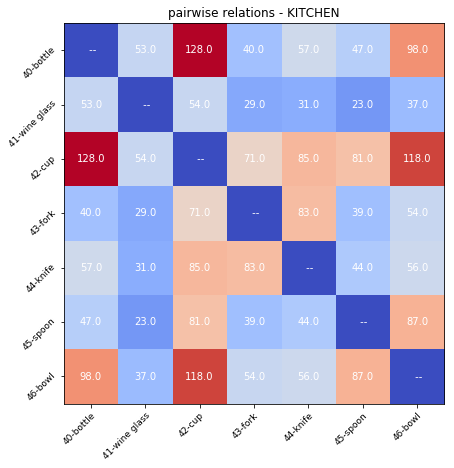

   indoor 7 matrix shape (7, 7)
   indices: [74, 75, 76, 77, 78, 79, 80] labels:  ['74-book', '75-clock', '76-vase', '77-scissors', '78-teddy bear', '79-hair drier', '80-toothbrush']


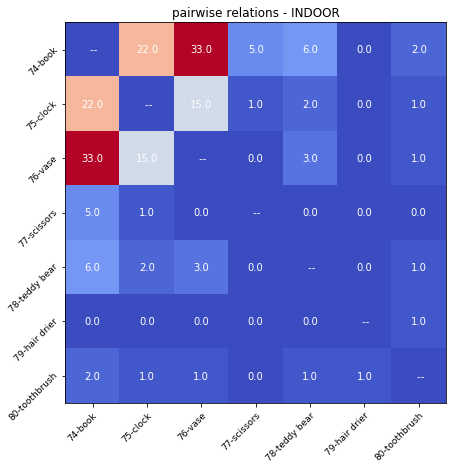

   appliance 5 matrix shape (5, 5)
   indices: [69, 70, 71, 72, 73] labels:  ['69-microwave', '70-oven', '71-toaster', '72-sink', '73-refrigerator']


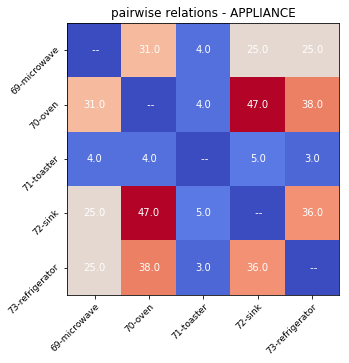

   vehicle 8 matrix shape (8, 8)
   indices: [2, 3, 4, 5, 6, 7, 8, 9] labels:  ['2-bicycle', '3-car', '4-motorcycle', '5-airplane', '6-bus', '7-train', '8-truck', '9-boat']


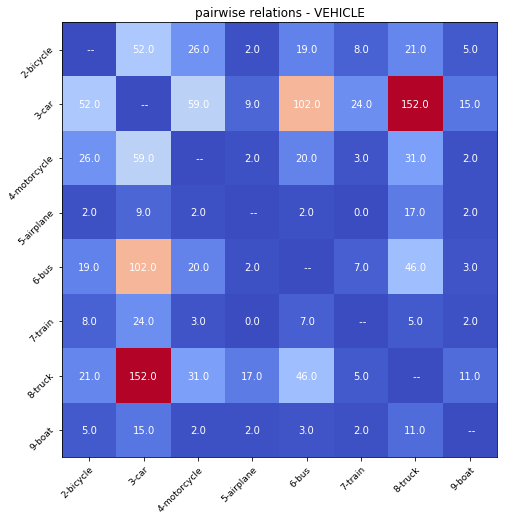

   food 10 matrix shape (10, 10)
   indices: [47, 48, 49, 50, 51, 52, 53, 54, 55, 56] labels:  ['47-banana', '48-apple', '49-sandwich', '50-orange', '51-broccoli', '52-carrot', '53-hot dog', '54-pizza', '55-donut', '56-cake']


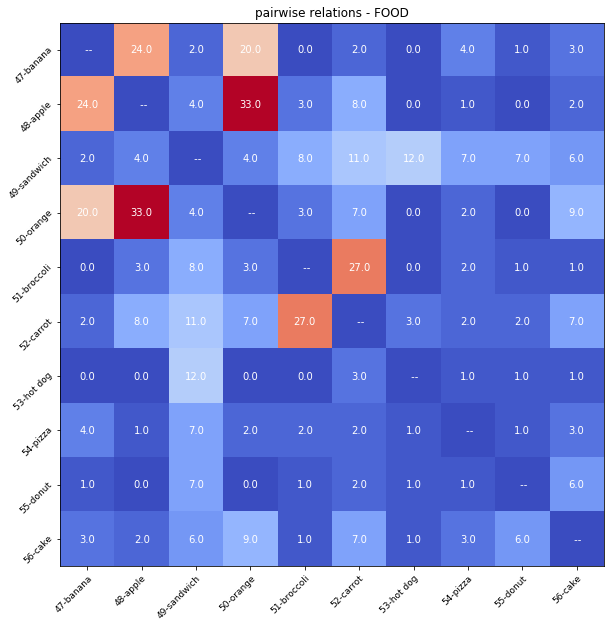

   person 1 matrix shape (1, 1)
   indices: [1] labels:  ['1-person']


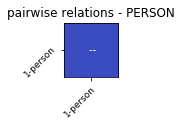

   animal 10 matrix shape (10, 10)
   indices: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24] labels:  ['15-bird', '16-cat', '17-dog', '18-horse', '19-sheep', '20-cow', '21-elephant', '22-bear', '23-zebra', '24-giraffe']


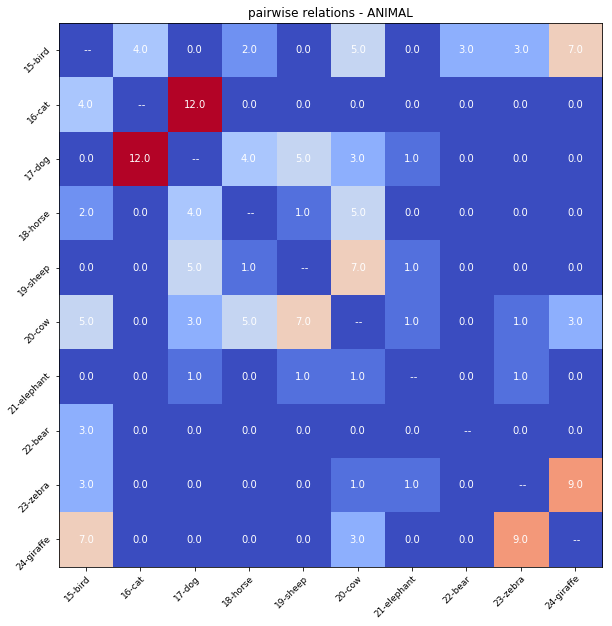

   electronic 6 matrix shape (6, 6)
   indices: [63, 64, 65, 66, 67, 68] labels:  ['63-tv', '64-laptop', '65-mouse', '66-remote', '67-keyboard', '68-cell phone']


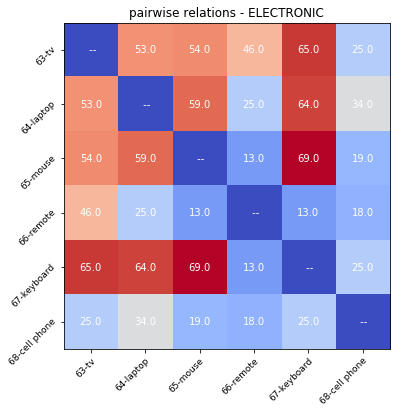

   accessory 5 matrix shape (5, 5)
   indices: [25, 26, 27, 28, 29] labels:  ['25-backpack', '26-umbrella', '27-handbag', '28-tie', '29-suitcase']


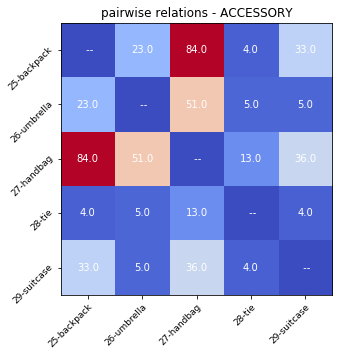

   sports 10 matrix shape (10, 10)
   indices: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39] labels:  ['30-frisbee', '31-skis', '32-snowboard', '33-sports ball', '34-kite', '35-baseball bat', '36-baseball glove', '37-skateboard', '38-surfboard', '39-tennis racket']


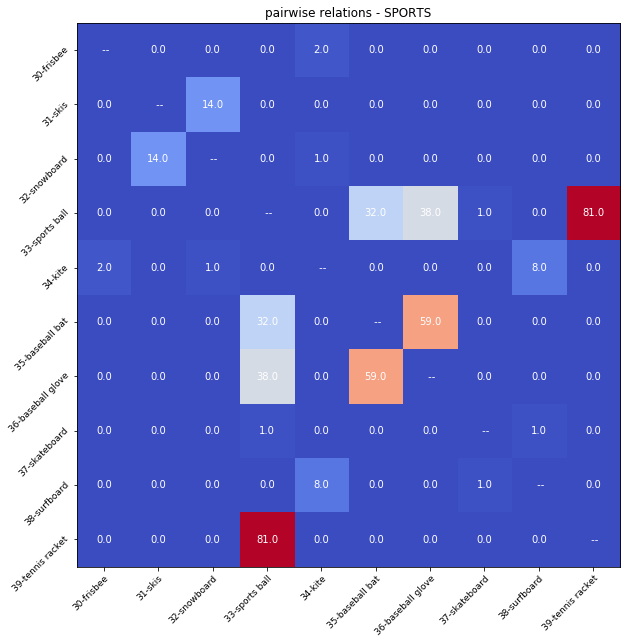

   outdoor 5 matrix shape (5, 5)
   indices: [10, 11, 12, 13, 14] labels:  ['10-traffic light', '11-fire hydrant', '12-stop sign', '13-parking meter', '14-bench']


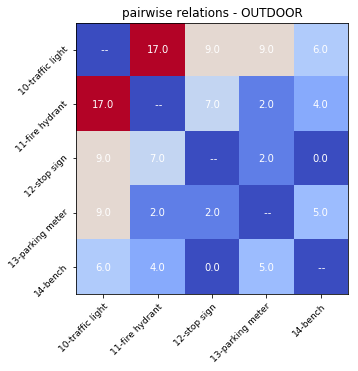

   furniture 6 matrix shape (6, 6)
   indices: [57, 58, 59, 60, 61, 62] labels:  ['57-chair', '58-couch', '59-potted plant', '60-bed', '61-dining table', '62-toilet']


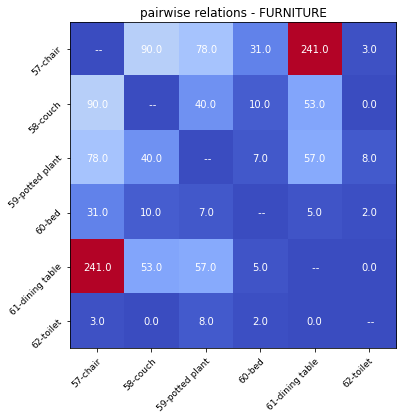

In [65]:
# fig = plt.figure(figsize=(20,20))
print(pairwise_matrix.shape)
for category in category_to_class_map:   #category_to_class_map:
    if category == 'background':
         continue
    indices = category_to_class_map[category]
    
    show_labels = [str(index)+'-'+dataset.class_names[index] for index in indices]
    show_matrix = (pairwise_matrix[indices])[:,indices]
    
    for i in range(show_matrix.shape[0]):
        show_matrix[i,i] = 0
    print( '  ',category, len(indices), 'matrix shape',show_matrix.shape)
    print( '   indices:',indices, 'labels: ', show_labels)
    category_ttl = ' - '+category
    hmfig = display_pairwise_heatmap(show_matrix, show_labels, category_ttl, cm.coolwarm)
    hmfig.savefig("E:\\Users\\Kevin.Bardool\\Desktop\\NN Related files\\"+category_ttl)

####  For a given category, get class_ids from `category_to_class_map`, and display heatmap 

(81, 81)
appliance     [69, 70, 71, 72, 73]
electronic     [63, 64, 65, 66, 67, 68]
electronic 11 matrix shape (11, 11)
       indices: [69, 70, 71, 72, 73, 63, 64, 65, 66, 67, 68] labels:  ['69-microwave', '70-oven', '71-toaster', '72-sink', '73-refrigerator', '63-tv', '64-laptop', '65-mouse', '66-remote', '67-keyboard', '68-cell phone']
   ext indices: [78, 79, 80, 81, 82, 72, 73, 74, 75, 76, 77] labels:  ['69-microwave', '70-oven', '71-toaster', '72-sink', '73-refrigerator', '63-tv', '64-laptop', '65-mouse', '66-remote', '67-keyboard', '68-cell phone']


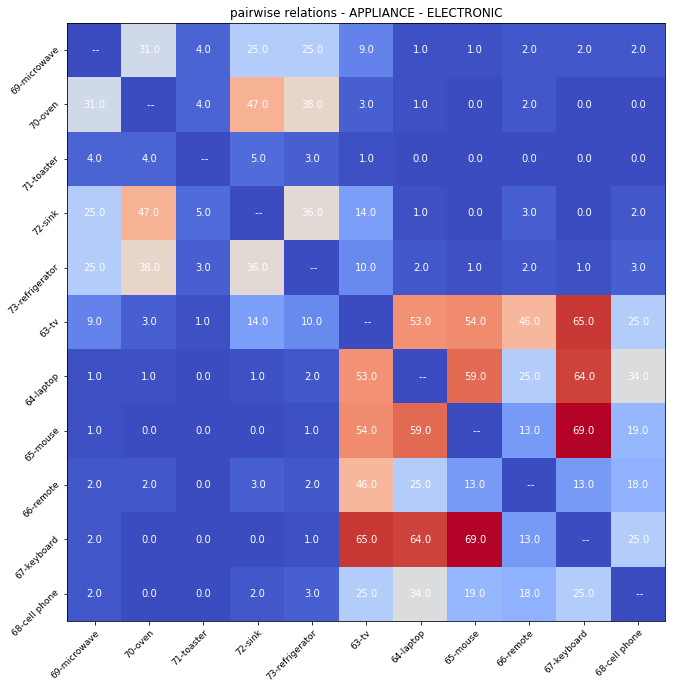

In [67]:

# fig = plt.figure(figsize=(20,20))
print(pairwise_matrix.shape)
indices = []
external_indices = []
category_ttl = ''
for category in ['appliance',  'electronic' ]:   #category_to_class_map:
    print(category, '   ', category_to_class_map[category])
    indices.extend(category_to_class_map[category])
    external_indices.extend(category_to_external_class_map[category])
#     print(' indices after adding ',category, '   ', indices)
    category_ttl += ' - '+category
show_labels = [str(index)+'-'+dataset.class_names[index] for index in indices]
show_matrix = (pairwise_matrix[indices])[:,indices]

# for i in range(show_matrix.shape[0]):
#     show_matrix[i,i] = 0
# print( category, len(indices), 'matrix shape',show_matrix.shape)
# print( '       indices:',indices, 'labels: ', show_labels)
# print( '   ext indices:',external_indices, 'labels: ', show_labels)

# print(show_matrix)
hmfig = display_pairwise_heatmap(show_matrix, show_labels, category_ttl)
# hmfig.savefig("E:\\Users\\Kevin.Bardool\\Desktop\\NN Related files\\"+category_ttl)

furniture     [57, 58, 59, 60, 61, 62]
electronic     [63, 64, 65, 66, 67, 68]


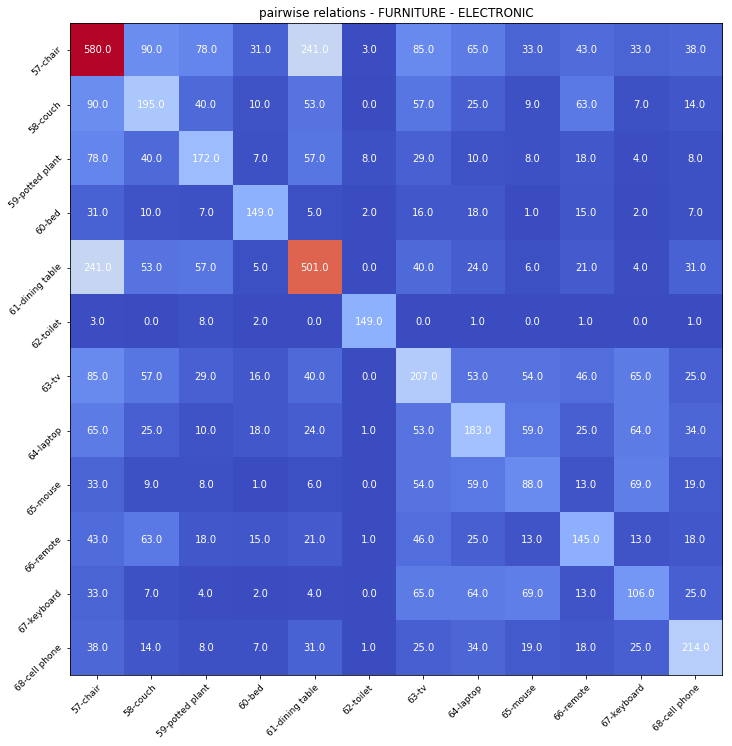

In [70]:
indices = []
external_indices = []
category_ttl = ''

for category in ['furniture',  'electronic' ]:   #category_to_class_map:
    print(category, '   ', category_to_class_map[category])
    indices.extend(category_to_class_map[category])
    external_indices.extend(category_to_external_class_map[category])
#     print(' indices after adding ',category, '   ', indices)
    category_ttl += ' - '+category
show_labels = [str(index)+'-'+dataset.class_names[index] for index in indices]
show_matrix = (pairwise_matrix[indices])[:,indices]
hmfig = display_pairwise_heatmap(show_matrix, show_labels, category_ttl)

furniture     [57, 58, 59, 60, 61, 62]
food     [47, 48, 49, 50, 51, 52, 53, 54, 55, 56]


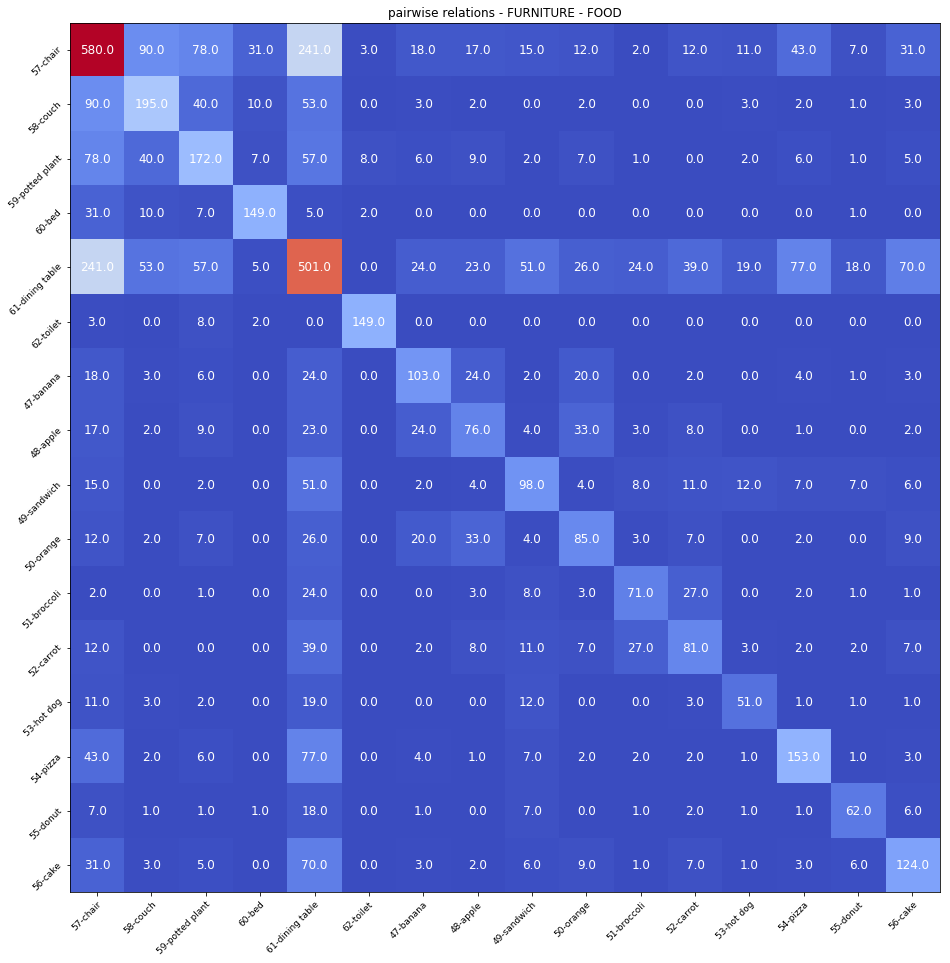

In [79]:
indices = []
external_indices = []
category_ttl = ''

for category in ['furniture',  'food' ]:   #category_to_class_map:
    print(category, '   ', category_to_class_map[category])
    indices.extend(category_to_class_map[category])
    external_indices.extend(category_to_external_class_map[category])
#     print(' indices after adding ',category, '   ', indices)
    category_ttl += ' - '+category
show_labels = [str(index)+'-'+dataset.class_names[index] for index in indices]
show_matrix = (pairwise_matrix[indices])[:,indices]
hmfig = display_pairwise_heatmap(show_matrix, show_labels, category_ttl)

furniture     [57, 58, 59, 60, 61, 62]
indoor     [74, 75, 76, 77, 78, 79, 80]


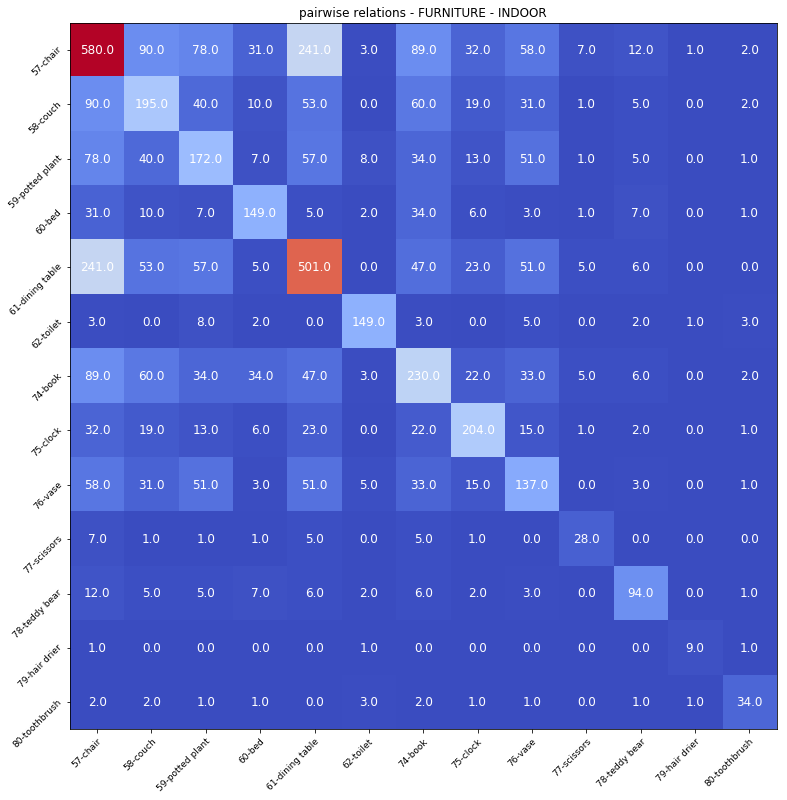

In [80]:
indices = []
external_indices = []
category_ttl = ''

for category in ['furniture',  'indoor' ]:   #category_to_class_map:
    print(category, '   ', category_to_class_map[category])
    indices.extend(category_to_class_map[category])
    external_indices.extend(category_to_external_class_map[category])
#     print(' indices after adding ',category, '   ', indices)
    category_ttl += ' - '+category
show_labels = [str(index)+'-'+dataset.class_names[index] for index in indices]
show_matrix = (pairwise_matrix[indices])[:,indices]
hmfig = display_pairwise_heatmap(show_matrix, show_labels, category_ttl)

### `display_pairwise_heatmap`

In [76]:
import matplotlib.pyplot as plt
def display_pairwise_heatmap(show_matrix, show_labels, category, colormap = cm.coolwarm):
    # show_labels = labels[1:10]
    num_classes = len(show_labels)
    #     print(' num classes: ', num_classes, 'matrix shape: ',show_matrix.shape)
     
    fig, ax = plt.subplots(1,1,figsize=(num_classes,num_classes))
    im = ax.imshow(show_matrix, cmap=colormap)
    # cmap=cm.bone, #  cmap=cm.Dark2 # cmap = cm.coolwarm   # cmap=cm.YlOrRd
    # We want to show all ticks...
    ax.set_xticks(np.arange(num_classes))
    ax.set_yticks(np.arange(num_classes))
    
    # ... and label them with the respective list entries
    ax.set_xticklabels(show_labels, size = 9)
    ax.set_yticklabels(show_labels, size = 9)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    for i in range(num_classes):
        for j in range(num_classes):
                text = ax.text(j, i, show_matrix[i, j], size=12, 
                           ha="center", va="center", color="w")
#             if i != j:
#                 text = ax.text(j, i, show_matrix[i, j],  
#                            ha="center", va="center", color="w")
#             else:
#                 text = ax.text(j, i, ' --',  
#                            ha="center", va="center", color="w")

    ax.set_title("pairwise relations"+category.upper())
    # fig.tight_layout()
    plt.show()
    return  fig

## HeatmapDataset

In [ ]:
HEATMAP_PATH = os.path.join(paths.DIR_DATASET,'coco2014_heatmaps')
print(HEATMAP_PATH)
from mrcnn.heatmap import HeatmapDataset
dataset = HeatmapDataset()

In [ ]:
dataset.load_heatmap(mrcnn_config.COCO_DATASET_PATH, HEATMAP_PATH, 'minival')
# def load_heatmap(self, dataset_dir, heatmap_dataset_dir, subset, class_ids=None,class_map=None, return_coco=False):
dataset.prepare()

#### simulate `load_heatmap()`

In [ ]:
dataset_dir =mrcnn_config.COCO_DATASET_PATH
heatmap_dataset_dir = HEATMAP_PATH
subset = 'minival'
class_ids=None
class_map=None
return_coco=False

In [ ]:
image_dir = os.path.join(dataset_dir, "train2014" if subset == "train" else "val2014")
heatmap_dir = os.path.join(heatmap_dataset_dir, "train2014" if subset == "train" else "val2014")
#       image_dir = os.path.join(dataset_dir, "train2017" if subset == "train" lse "val2017")
print(image_dir,'\n', heatmap_dir)
 
# Create COCO object
json_path_dict = {
    "train"  :  "annotations/instances_train2014.json",
    "val"    :  "annotations/instances_val2014.json",
    "minival":  "annotations/instances_minival2014.json",
    "val35k" :  "annotations/instances_valminusminival2014.json",
    "test"   :  "annotations/image_info_test2014.json"
}
print('subset: ', subset, 'json_path_dir: ', json_path_dict[subset])
coco = COCO(os.path.join(dataset_dir, json_path_dict[subset]))

In [ ]:
# Load all classes or a subset?
if not class_ids:
    # All classes
    class_ids = sorted(coco.getCatIds())
print(' ClassIds     :', class_ids)

In [ ]:
##--------------------------------------------------------------
## Get image ids - using COCO
##--------------------------------------------------------------
#All images or a subset?
if class_ids:
    print(' Subset of classes')
    image_ids = []
    for id in class_ids:
        image_ids.extend(list(coco.getImgIds(catIds=[id])))
    # Remove duplicates
    image_ids = list(set(image_ids))
else:
    # All images
    class_ids = sorted(coco.getCatIds())
    print(' All classes')    
    image_ids = list(coco.imgs.keys())
    
print(' ClassIds     : ', len(class_ids))
print(' Image ids    : ', len(image_ids))

In [ ]:
# # Add classes to dataset.class_info structure
for i in class_ids:
    dataset.add_class("coco", i, coco.loadCats(i)[0]["name"])

In [ ]:
len(dataset.class_info)
# image_ids[:20]

In [ ]:
# # print(' ClassIds     :', class_ids)
# # Add images to dataset.image_info structure
dataset.image_info = []
heatmap_notfound=  heatmap_found = 0
print(heatmap_notfound, heatmap_found)
for i in image_ids:
    print('image id: ',i)
    heatmap_filename = 'hm_{:012d}.npz'.format(i)
    heatmap_path = os.path.join(heatmap_dir, heatmap_filename) 
    
    ## Only load image_info data structure for images where the corrsponding 
    ## heatmap .npz file exist
    if not os.path.isfile(heatmap_path):
        print('file not found:::',heatmap_filename)
        heatmap_notfound += 1
    else:
        dataset.add_image(
            "coco", image_id=i,
            path=os.path.join(image_dir, coco.imgs[i]['file_name']),
            width=coco.imgs[i]["width"],
            height=coco.imgs[i]["height"],
            heatmap_path=heatmap_path
          )
        heatmap_found += 1
        # annotations=coco.loadAnns(coco.getAnnIds(imgIds=[i], catIds=class_ids, iscrowd=None)))
        
        
print(' Images ids :', len(image_ids))
print('    Corresponding heatmap found     :' , heatmap_found)
print('    Corresponding heatmap not found :' , heatmap_notfound)
print(' Total      :', heatmap_found + heatmap_notfound)

In [ ]:
print(len(dataset.image_ids))
print(len(dataset.image_info))
print(dataset.image_info[0])
# print(dataset.image_info[5000])

In [ ]:
##--------------------------------------------------------------
## Get image ids - using walk on HEATMAP_PATH
##--------------------------------------------------------------
print(' image dir        : ', image_dir) 
print(' json_path_dir    : ', os.path.join(dataset_dir, json_path_dict[subset]))
regex = re.compile(".*/\w+(\d{12})\.jpg")


image_ids = [] 
heatmap_files = next(os.walk(heatmap_dir))[2]
print('heat ap dir :' , heatmap_dir)

In [ ]:
for hm_file in heatmap_files:
    print(' Processing file: ', hm_file)
    heatmap_path=os.path.join(heatmap_dir, hm_file) 
    i = int(os.path.splitext(hm_file.lstrip('hm_'))[0])
    loaddata = np.load(heatmap_path)
    print(loaddata['coco_info'])
    coco_id = loaddata['coco_info'][0]
    coco_filename = loaddata['coco_info'][1]
    input_image_meta = loaddata['input_image_meta']
    loaddata.close()
    dataset.add_image(
        "coco", 
        image_id=i,
        path=os.path.join(image_dir, coco.imgs[i]['file_name']),
        width=coco.imgs[i]["width"],
        height=coco.imgs[i]["height"],
        heatmap_path=os.path.join(heatmap_dir, 'hm_{:012d}'.format(i)) 
      )    
#     print(input_filename, type(input_filename), len(input_filename))
#     coco_filename = input_filename.replace('\\' , "/")
#     print(coco_filename)
#     regex_match  = regex.match(input_filename)            
#     # Add images to dataset.image_info structure
#     if regex_match:
#         coco_id = int(regex_match.group(1))
#     print(i, input_image_meta[:8],' ', input_filename, ' coco_id : ',coco_id)

#     self.add_image(
#         "coco", 
#         image_id=i,
#         path = input_filename,
#         height=input_image_meta[1],
#         width= input_image_meta[2],
#         heatmap_path=heatmap_path
#       )
#     image_ids.append(i)
#         # annotations=coco.loadAnns(coco.getAnnIds(imgIds=[i], catIds=class_ids, iscrowd=None)))
# print(' number of images : ', len(image_ids))

#### Define data generator

In [ ]:
from mrcnn.datagen_fcn import fcn_data_generator, fcn_data_gen_simulate
##--------------------------------------------------------------------------------
## Data generators
##--------------------------------------------------------------------------------
generator = fcn_data_generator(dataset, mrcnn_config, shuffle=True,
                                 batch_size=mrcnn_config.BATCH_SIZE)
# val_generator   = data_generator(dataset_val, mrcnn_model.config, shuffle=True,
#                                  batch_size=mrcnn_config.BATCH_SIZE,
#                                  augment=False)

In [ ]:
train_batch_x, train_batch_y = next(generator)

for i in train_batch_x:
    print(type(i), i.shape, i.dtype)
for i in train_batch_y:
    print(type(i), i.shape)
print(train_batch_y)  

In [ ]:
# imgmeta_idx = mrcnn_model.keras_model.input_names.index('input_image_meta')
from mrcnn.visualize import plot_2d_heatmap_compare
import mrcnn.utils as utils
# def plot_2d_heatmap_compare( Z1, Z2, boxes, image_idx, class_ids,  size = None, 
#                                  num_bboxes = 0, class_names=None, scale = 1,
#                                  title = '2D Comparison between 2d heatmaps w/ bboxes'):
train_batch_x, train_batch_y = fcn_data_gen_simulate(dataset, mrcnn_config, [210])
img_meta    = train_batch_x[1]
class_names = dataset.class_names
print(img_meta.shape)
for img_idx in range(mrcnn_config.BATCH_SIZE):
    print(img_meta[img_idx])
    image_id = img_meta[img_idx,0]
    image = dataset.load_image(image_id)
    timg  = train_batch_x[0][img_idx]
    print(' image from train_batch_x :', timg.shape, timg.dtype, np.min(timg), np.max(timg))
    print(' image from dataset load  :', image.shape, image.dtype, np.min(image), np.max(image))
    ## Display image, and mean-subtracted image
    visualize.display_image_bw(image)
#     visualize.display_images([image, train_batch_x[0][img_idx]], cols = 2, width = 18)
    
    ## display masks and bounding boxes
    mask, class_ids = dataset.load_mask(image_id)
    print('class_ids:', class_ids)
    bbox = utils.extract_bboxes(mask)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)
    visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset.class_names, figsize =(8,8)) 
    

    ## display ground truth heatmaps
    gt_class_ids = np.unique(train_batch_x[5][img_idx,:,:,4]).astype(int).tolist()
    print('Image : {}  GT ClassIds: {}'.format(img_idx, gt_class_ids))
#     visualize.plot_2d_heatmap_no_bboxes(train_batch_x[4],img_idx, columns = 4, class_names=class_names)    
    visualize.plot_2d_heatmap_no_bboxes(train_batch_x[4], img_idx,class_ids = gt_class_ids, columns = 4, class_names=class_names)
    
    
    ## display predicted heatmaps
    pr_class_ids = np.unique(train_batch_x[3][img_idx,:,:,4]).astype(int).tolist()
    print('Image : {}  PR ClassIds: {}'.format(img_idx, pr_class_ids))
#     visualize.plot_2d_heatmap_no_bboxes(train_batch_x[2],img_idx, columns = 4, class_names=class_names)
    visualize.plot_2d_heatmap_no_bboxes(train_batch_x[2], img_idx,class_ids = gt_class_ids, columns = 4, class_names=class_names)
        

In [ ]:
from mrcnn.utils import unresize_image
from   matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import skimage.util
import skimage.io
paths.display()


In [ ]:
# ds = os.path.join(paths.COCO_DATASET_PATH,'val2014/COCO_val2014_000000017031.jpg')
ds = dataset.image_info[210]['path']
print(ds)
im = skimage.io.imread(ds)
print(im.shape, im.dtype, np.min(im), np.max(im))
# im = skimage.io.imread(ds)
# im = Image.open(ds)

In [ ]:
print('image    : ', image.shape, image.dtype)
image_bw = Image.fromarray(image).convert(mode='L')
# print('image_bw : ', image_bw.shape, image_bw.dtype)

molded_image, window, scale, padding = utils.resize_image(
    image,
    min_dim=mrcnn_config.IMAGE_MIN_DIM,
    max_dim=mrcnn_config.IMAGE_MAX_DIM,
    padding=mrcnn_config.IMAGE_PADDING)
print('molded_image   : ', molded_image.shape, molded_image.dtype)
print(' image meta    :', train_batch_x[1][0])

unresized_image = unresize_image(molded_image,train_batch_x[1][0])
print('unresized_image : ', unresized_image.shape, unmolded_image.dtype)

unresized_image_bw = np.asarray(Image.fromarray(unresized_image).convert(mode='L'))
print('unresized_image_bw: ',unresized_image_bw.shape, unresized_image_bw.dtype)


unmolded_image = utils.unmold_image(molded_image, mrcnn_config)
print('unmolded_image : ', unmolded_image.shape, unmolded_image.dtype)

unmolded_image_bw = np.asarray(Image.fromarray(unmolded_image).convert(mode='L'))
print('unmolded_image_bw : ', unmolded_image_bw.shape, unmolded_image_bw.dtype)


unmolded_heatmap = unresize_image(train_batch_x[2][0,:,:,24],train_batch_x[1][0], upscale = mrcnn_config.HEATMAP_SCALE_FACTOR)
print('unmolded_heatmap : ', unmolded_heatmap.shape, unmolded_heatmap.dtype)


print(train_batch_x[2][0,:,:,24].dtype)




In [ ]:
import matplotlib.pyplot as plt
print('Orig image shape: ', image.shape)
print('Image window is : ', window)
print('Scale is        : ', scale)
print(train_batch_x[1][0,:8])
print('Padding is :', padding)
fig = plt.figure(frameon=False, figsize=(10,10))
im1 = plt.imshow(molded_image)



fig = plt.figure(frameon=False, figsize=(10,10))
im1 = plt.imshow(unresized_image)
fig = plt.figure(frameon=False, figsize=(10,10))
im1 = plt.imshow(unresized_image_bw, cmap=plt.cm.gray)

fig = plt.figure(frameon=False, figsize=(10,10))
im1 = plt.imshow(unmolded_image)
fig = plt.figure(frameon=False, figsize=(10,10))
im1 = plt.imshow(unmolded_image_bw, cmap=plt.cm.gray)
# fig = plt.figure(frameon=False, figsize=(10,10))
# im1 = plt.imshow(unmolded_image_bw)

# fig = plt.figure(frameon=False, figsize=(10,10))
# im1 = plt.imshow(unmolded_heatmap,cmap = cm.YlOrRd)


# fig = plt.figure(frameon=False, figsize=(10,10))
# im1 = plt.imshow(unmolded_image , cmap=plt.cm.gray)
# im1 = plt.imshow(unmolded_heatmap, alpha = 0.6,cmap=cm.YlOrRd)  


# fig = plt.figure(frameon=False, figsize=(10,10))
# im1 = plt.imshow(image_bw , cmap=plt.cm.gray)
# im1 = plt.imshow(unmolded_heatmap, alpha = 0.6,cmap=cm.YlOrRd)  
plt.show()

In [ ]:
from mrcnn.visualize import display_heatmaps, display_heatmaps_fcn, display_heatmaps_mrcnn
# visualize.display_image_bw(image)
display_heatmaps(train_batch_x, 0, hm = 'pr', config = mrcnn_config, class_ids = [0,1,2,3,4,5,24], class_names = dataset.class_names)
# display_heatmaps(train_batch_x, 0, hm = 'gt', config = mrcnn_config, class_ids = [0,1,2,3,4,5,24], class_names = dataset.class_names)